# VAE Implementation

Python version: 3.8.8

In [50]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

# create directory to save results
!mkdir VAE_results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


In [51]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_var = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        means = self.fc2_mu(h)
        log_variances = self.fc2_var(h)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5 * log_variances)
        eps = torch.randn_like(std)
        return means + eps * std

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        probabilties = torch.sigmoid(self.fc4(h3))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means, log_variances = self.encode(x.view(-1,784))
        z = self.reparameterize(means, log_variances)
        return self.decode(z), means, log_variances


## Loss Functions

In [52]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(
        reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    BCE = F.binary_cross_entropy(
        reconstructed_x, x.view(-1,784), reduction='sum'
    )
    KL_div = -0.5 * torch.sum(1 + log_variances - means**2 - torch.exp(log_variances))
    return BCE + KL_div, BCE


## Training

In [68]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#


def vae_train(epoch, model, optimizer):
    train_BCE = 0
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, means, log_variances = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
            loss.backward()
            train_BCE += BCE.item()
            train_loss += loss.item()
            optimizer.step()
            # if batch_idx % log_interval == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE: {:.6f}, Loss: {:.6f}'.format(
            #         epoch, batch_idx * len(data), len(train_loader.dataset),
            #         100. * batch_idx / len(train_loader),
            #         BCE.item() / len(data), loss / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    average_train_loss = train_loss / len(train_loader.dataset)
    print('Epoch: {} Average BCE: {:.4f}, Average Loss: {:.4f}'.format(
        epoch, average_train_BCE, average_train_loss))
    return average_train_loss, average_train_BCE


## Testing

In [64]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'VAE_results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print(
                    'Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('VAE_results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_BCE = 0
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mean, log_variances = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, mean, log_variances)
            test_BCE += BCE.item()
            test_loss += loss
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'VAE_results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print(
                    'Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('VAE_results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    average_test_loss = test_loss / len(test_loader.dataset)
    print('====> Test set BCE: {:.4f}, Test set Loss: {:.4f}'.format(average_test_BCE, average_test_loss))
    return average_test_loss, average_test_BCE


## Main

==================== DAE =====================
Epoch: 1 Average loss: 129.9377
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


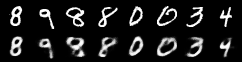

====> Test set loss: 88.1431
Epoch: 2 Average loss: 82.8777
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


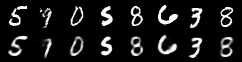

====> Test set loss: 77.8567
Epoch: 3 Average loss: 76.8707
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


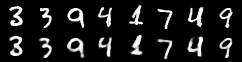

====> Test set loss: 74.4130
Epoch: 4 Average loss: 74.0985
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


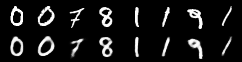

====> Test set loss: 72.4259
Epoch: 5 Average loss: 72.3293
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


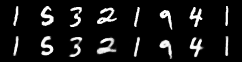

====> Test set loss: 71.0949
Epoch: 6 Average loss: 71.0864
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


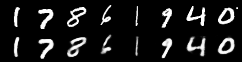

====> Test set loss: 69.9961
Epoch: 7 Average loss: 70.0918
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


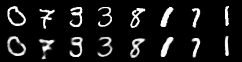

====> Test set loss: 69.3027
Epoch: 8 Average loss: 69.3178
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


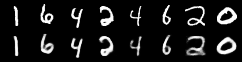

====> Test set loss: 68.6645
Epoch: 9 Average loss: 68.6761
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


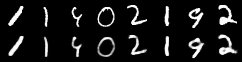

====> Test set loss: 68.2610
Epoch: 10 Average loss: 68.1468
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


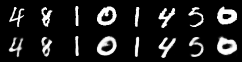

====> Test set loss: 67.9903
Epoch: 11 Average loss: 67.7140
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


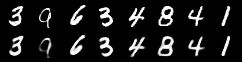

====> Test set loss: 67.4653
Epoch: 12 Average loss: 67.3382
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


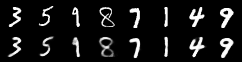

====> Test set loss: 67.1589
Epoch: 13 Average loss: 67.0116
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


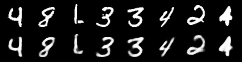

====> Test set loss: 66.9794
Epoch: 14 Average loss: 66.7320
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


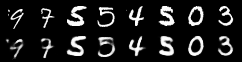

====> Test set loss: 66.7817
Epoch: 15 Average loss: 66.4613
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


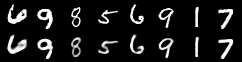

====> Test set loss: 66.5109
Epoch: 16 Average loss: 66.2368
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


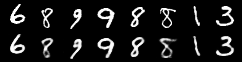

====> Test set loss: 66.3818
Epoch: 17 Average loss: 66.0271
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


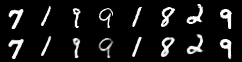

====> Test set loss: 66.2725
Epoch: 18 Average loss: 65.8370
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


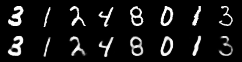

====> Test set loss: 66.1121
Epoch: 19 Average loss: 65.6851
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


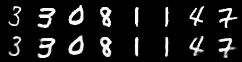

====> Test set loss: 65.9585
Epoch: 20 Average loss: 65.5132
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


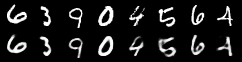

====> Test set loss: 65.8981
Epoch: 21 Average loss: 65.3553
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


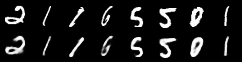

====> Test set loss: 65.7297
Epoch: 22 Average loss: 65.2423
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


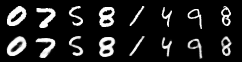

====> Test set loss: 65.6436
Epoch: 23 Average loss: 65.1058
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


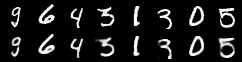

====> Test set loss: 65.6445
Epoch: 24 Average loss: 64.9907
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


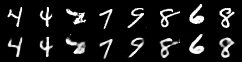

====> Test set loss: 65.4714
Epoch: 25 Average loss: 64.8682
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


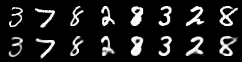

====> Test set loss: 65.3317
Epoch: 26 Average loss: 64.7661
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


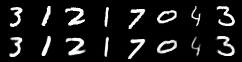

====> Test set loss: 65.3378
Epoch: 27 Average loss: 64.6777
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


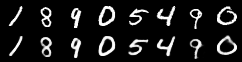

====> Test set loss: 65.2700
Epoch: 28 Average loss: 64.5752
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


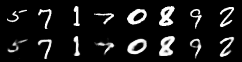

====> Test set loss: 65.1293
Epoch: 29 Average loss: 64.4840
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


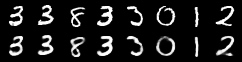

====> Test set loss: 65.0845
Epoch: 30 Average loss: 64.4046
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


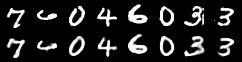

====> Test set loss: 65.0872
Epoch: 31 Average loss: 64.3354
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


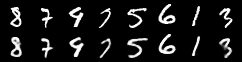

====> Test set loss: 65.0142
Epoch: 32 Average loss: 64.2435
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


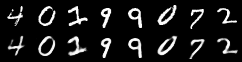

====> Test set loss: 64.9754
Epoch: 33 Average loss: 64.1779
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


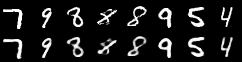

====> Test set loss: 64.8418
Epoch: 34 Average loss: 64.0983
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


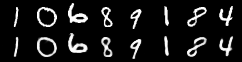

====> Test set loss: 64.9784
Epoch: 35 Average loss: 64.0454
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


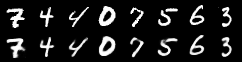

====> Test set loss: 64.8395
Epoch: 36 Average loss: 63.9806
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


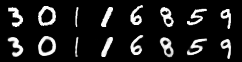

====> Test set loss: 64.7523
Epoch: 37 Average loss: 63.9196
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


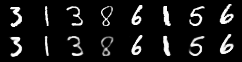

====> Test set loss: 64.7419
Epoch: 38 Average loss: 63.8601
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


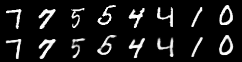

====> Test set loss: 64.8130
Epoch: 39 Average loss: 63.8146
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


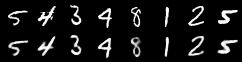

====> Test set loss: 64.8240
Epoch: 40 Average loss: 63.7563
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


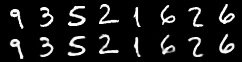

====> Test set loss: 64.7649
Epoch: 41 Average loss: 63.7038
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


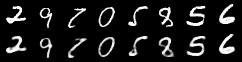

====> Test set loss: 64.6606
Epoch: 42 Average loss: 63.6573
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


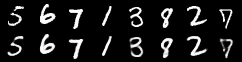

====> Test set loss: 64.6058
Epoch: 43 Average loss: 63.6119
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


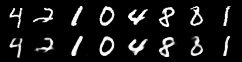

====> Test set loss: 64.5720
Epoch: 44 Average loss: 63.5654
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


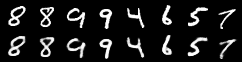

====> Test set loss: 64.5749
Epoch: 45 Average loss: 63.5228
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


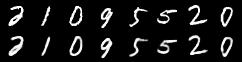

====> Test set loss: 64.5142
Epoch: 46 Average loss: 63.4845
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


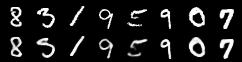

====> Test set loss: 64.4569
Epoch: 47 Average loss: 63.4428
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


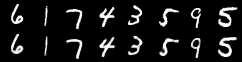

====> Test set loss: 64.4787
Epoch: 48 Average loss: 63.4013
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


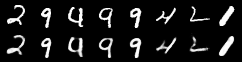

====> Test set loss: 64.4028
Epoch: 49 Average loss: 63.3717
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


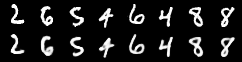

====> Test set loss: 64.4537
Epoch: 50 Average loss: 63.3274
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


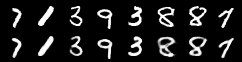

====> Test set loss: 64.4075


==================== VAE =====================
Epoch: 1 Average BCE: 149.4186, Average Loss: 164.9871
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


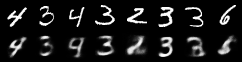

====> Test set BCE: 107.1963, Test set Loss: 128.2402
Epoch: 2 Average BCE: 99.8281, Average Loss: 122.1831
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


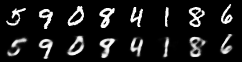

====> Test set BCE: 92.0790, Test set Loss: 116.4872
Epoch: 3 Average BCE: 90.7793, Average Loss: 114.8682
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


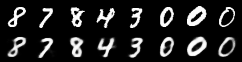

====> Test set BCE: 87.8422, Test set Loss: 112.0998
Epoch: 4 Average BCE: 87.2306, Average Loss: 111.9237
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


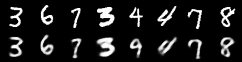

====> Test set BCE: 84.6912, Test set Loss: 110.0772
Epoch: 5 Average BCE: 85.2268, Average Loss: 110.1999
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


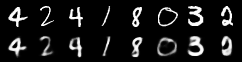

====> Test set BCE: 83.6781, Test set Loss: 108.9099
Epoch: 6 Average BCE: 83.9261, Average Loss: 109.0009
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


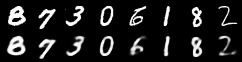

====> Test set BCE: 82.7075, Test set Loss: 107.6586
Epoch: 7 Average BCE: 82.9430, Average Loss: 108.1569
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


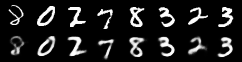

====> Test set BCE: 81.5382, Test set Loss: 107.1652
Epoch: 8 Average BCE: 82.2117, Average Loss: 107.5285
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


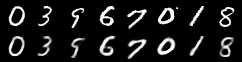

====> Test set BCE: 81.4309, Test set Loss: 106.7367
Epoch: 9 Average BCE: 81.6287, Average Loss: 106.9596
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


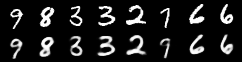

====> Test set BCE: 81.3647, Test set Loss: 106.3652
Epoch: 10 Average BCE: 81.1916, Average Loss: 106.6260
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


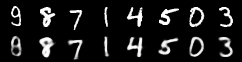

====> Test set BCE: 81.0546, Test set Loss: 105.9904
Epoch: 11 Average BCE: 80.7584, Average Loss: 106.2083
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


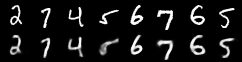

====> Test set BCE: 80.3559, Test set Loss: 105.5572
Epoch: 12 Average BCE: 80.4386, Average Loss: 105.9188
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


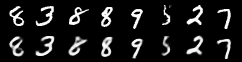

====> Test set BCE: 79.6842, Test set Loss: 105.2716
Epoch: 13 Average BCE: 80.1242, Average Loss: 105.6161
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


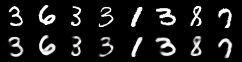

====> Test set BCE: 79.6233, Test set Loss: 105.3012
Epoch: 14 Average BCE: 79.8792, Average Loss: 105.3883
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


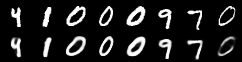

====> Test set BCE: 80.1760, Test set Loss: 105.1406
Epoch: 15 Average BCE: 79.6133, Average Loss: 105.1780
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


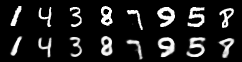

====> Test set BCE: 79.0976, Test set Loss: 104.6700
Epoch: 16 Average BCE: 79.4089, Average Loss: 104.9655
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


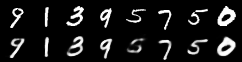

====> Test set BCE: 78.4919, Test set Loss: 104.4421
Epoch: 17 Average BCE: 79.2310, Average Loss: 104.8105
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


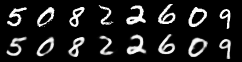

====> Test set BCE: 78.8348, Test set Loss: 104.5778
Epoch: 18 Average BCE: 79.0477, Average Loss: 104.6328
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


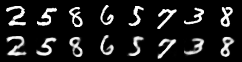

====> Test set BCE: 78.8166, Test set Loss: 104.3617
Epoch: 19 Average BCE: 78.9193, Average Loss: 104.5361
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


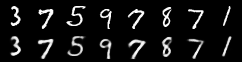

====> Test set BCE: 78.2470, Test set Loss: 104.1168
Epoch: 20 Average BCE: 78.7421, Average Loss: 104.3534
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


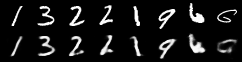

====> Test set BCE: 78.7562, Test set Loss: 103.9986
Epoch: 21 Average BCE: 78.6129, Average Loss: 104.2040
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


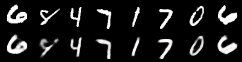

====> Test set BCE: 78.1452, Test set Loss: 103.9691
Epoch: 22 Average BCE: 78.5096, Average Loss: 104.1544
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


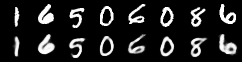

====> Test set BCE: 78.7066, Test set Loss: 103.7942
Epoch: 23 Average BCE: 78.3664, Average Loss: 104.0000
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


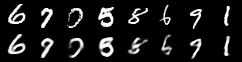

====> Test set BCE: 78.5690, Test set Loss: 103.7319
Epoch: 24 Average BCE: 78.2281, Average Loss: 103.8455
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


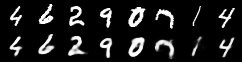

====> Test set BCE: 78.3113, Test set Loss: 103.6110
Epoch: 25 Average BCE: 78.1774, Average Loss: 103.7980
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


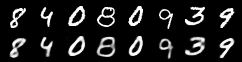

====> Test set BCE: 77.8260, Test set Loss: 103.4855
Epoch: 26 Average BCE: 78.0130, Average Loss: 103.6442
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


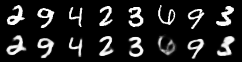

====> Test set BCE: 77.8929, Test set Loss: 103.5916
Epoch: 27 Average BCE: 77.9755, Average Loss: 103.5891
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


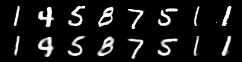

====> Test set BCE: 77.3511, Test set Loss: 103.6011
Epoch: 28 Average BCE: 77.8471, Average Loss: 103.4667
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


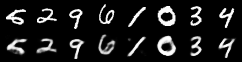

====> Test set BCE: 77.9165, Test set Loss: 103.3761
Epoch: 29 Average BCE: 77.7639, Average Loss: 103.3867
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


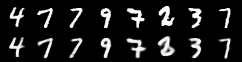

====> Test set BCE: 77.7083, Test set Loss: 103.2614
Epoch: 30 Average BCE: 77.7094, Average Loss: 103.2929
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


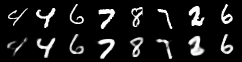

====> Test set BCE: 77.8903, Test set Loss: 103.2686
Epoch: 31 Average BCE: 77.6028, Average Loss: 103.2257
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


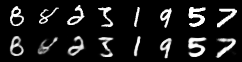

====> Test set BCE: 77.5520, Test set Loss: 103.2586
Epoch: 32 Average BCE: 77.5222, Average Loss: 103.1393
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


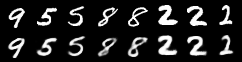

====> Test set BCE: 77.3718, Test set Loss: 103.1540
Epoch: 33 Average BCE: 77.4218, Average Loss: 103.0361
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


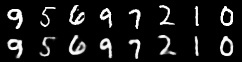

====> Test set BCE: 78.3984, Test set Loss: 103.3456
Epoch: 34 Average BCE: 77.3646, Average Loss: 102.9847
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


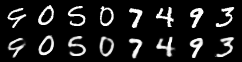

====> Test set BCE: 77.6044, Test set Loss: 102.9296
Epoch: 35 Average BCE: 77.3561, Average Loss: 102.9445
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


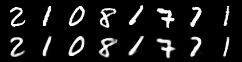

====> Test set BCE: 77.0966, Test set Loss: 103.0246
Epoch: 36 Average BCE: 77.2455, Average Loss: 102.8380
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


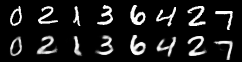

====> Test set BCE: 77.2381, Test set Loss: 102.8537
Epoch: 37 Average BCE: 77.1930, Average Loss: 102.7793
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


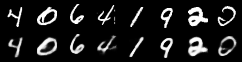

====> Test set BCE: 77.3997, Test set Loss: 102.8195
Epoch: 38 Average BCE: 77.1471, Average Loss: 102.7029
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


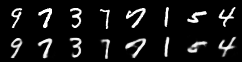

====> Test set BCE: 77.1035, Test set Loss: 102.7373
Epoch: 39 Average BCE: 77.0856, Average Loss: 102.6765
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


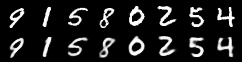

====> Test set BCE: 77.1901, Test set Loss: 102.8399
Epoch: 40 Average BCE: 77.0145, Average Loss: 102.5799
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


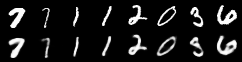

====> Test set BCE: 76.5627, Test set Loss: 102.6557
Epoch: 41 Average BCE: 76.9869, Average Loss: 102.5579
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


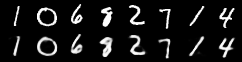

====> Test set BCE: 77.3357, Test set Loss: 102.6665
Epoch: 42 Average BCE: 76.9164, Average Loss: 102.4877
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


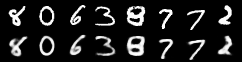

====> Test set BCE: 77.5060, Test set Loss: 102.5091
Epoch: 43 Average BCE: 76.8509, Average Loss: 102.4097
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


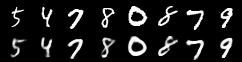

====> Test set BCE: 77.5758, Test set Loss: 102.6000
Epoch: 44 Average BCE: 76.8145, Average Loss: 102.4023
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


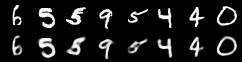

====> Test set BCE: 77.1351, Test set Loss: 102.4303
Epoch: 45 Average BCE: 76.7554, Average Loss: 102.3459
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


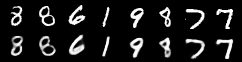

====> Test set BCE: 76.6350, Test set Loss: 102.4510
Epoch: 46 Average BCE: 76.7179, Average Loss: 102.2672
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


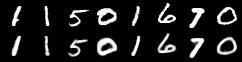

====> Test set BCE: 76.9719, Test set Loss: 102.4576
Epoch: 47 Average BCE: 76.6781, Average Loss: 102.2520
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


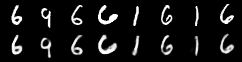

====> Test set BCE: 77.0857, Test set Loss: 102.3463
Epoch: 48 Average BCE: 76.6309, Average Loss: 102.1673
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


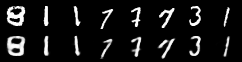

====> Test set BCE: 76.8587, Test set Loss: 102.2480
Epoch: 49 Average BCE: 76.6168, Average Loss: 102.1901
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


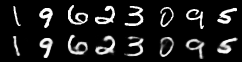

====> Test set BCE: 77.0577, Test set Loss: 102.3040
Epoch: 50 Average BCE: 76.5361, Average Loss: 102.0654
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


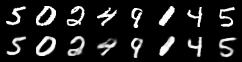

====> Test set BCE: 77.0119, Test set Loss: 102.4528


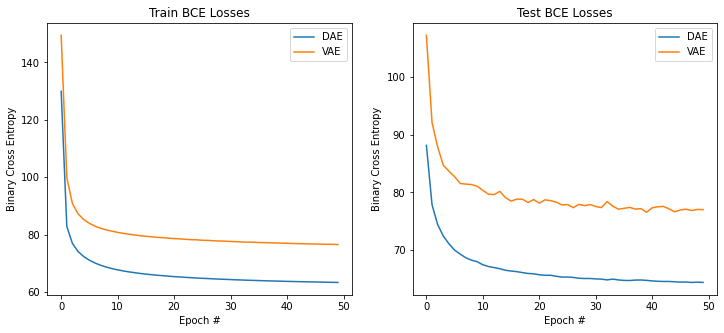

In [69]:
# train and test DAE
epochs = 50
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
print("==================== DAE =====================")
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'VAE_results/sample_dae_' + str(epoch) + '.png')

print('\n')
# train and test VAE
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
print("==================== VAE =====================")
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'VAE_results/sample_vae_' + str(epoch) + '.png')

_, (a1, a2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot Train BCE Losses
a1.plot(dae_average_train_BCE)
a1.plot(vae_average_train_BCE)
a1.set_title('Train BCE Losses')
a1.set_ylabel('Binary Cross Entropy')
a1.set_xlabel('Epoch #')
a1.legend(['DAE','VAE'], loc='upper right')

# Plot Test BCE Losses
a2.plot(dae_average_test_BCE)
a2.plot(vae_average_test_BCE)
a2.set_title('Test BCE Losses')
a2.set_ylabel('Binary Cross Entropy')
a2.set_xlabel('Epoch #')
a2.legend(['DAE','VAE'], loc='upper right')
plt.show()


The DAE model has a smaller train loss and test loss, since DAE is better than VAE in reconstructing samples. If we look at the reconstructed images, we can see that DAE has closer image to the original one. VAE's reconstructed images are more blurred. The difference between the reconstructed images causes the bigger loss of traning and testing in VAE.

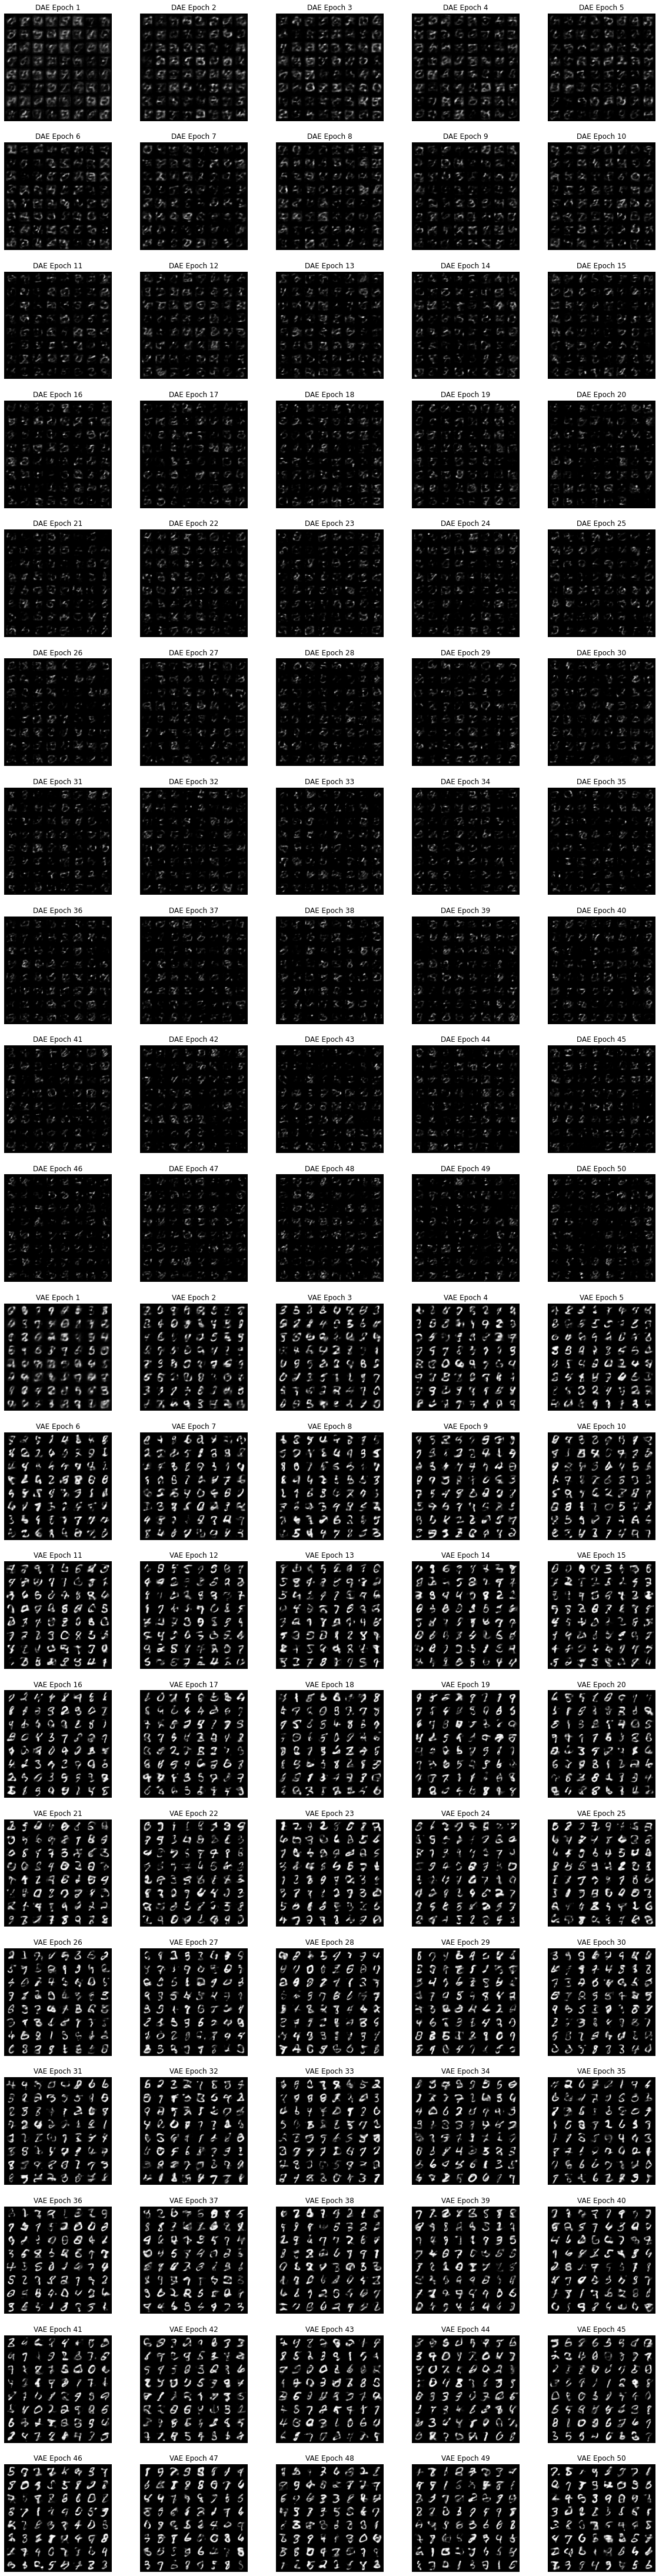

In [70]:
_, axis = plt.subplots(20, 5, figsize=(20, 80))

# display images for DAE
for e in range(epochs):
    img_d = mpimg.imread('VAE_results/sample_dae_' + str(e+1) + '.png')
    axis[e//5, e % 5].imshow(img_d)
    axis[e//5, e % 5].axis('off')
    axis[e//5, e % 5].set_title(f"DAE Epoch {e+1}")
    img_v = mpimg.imread('VAE_results/sample_vae_' + str(e+1) + '.png')
    axis[10+e//5, e % 5].imshow(img_v)
    axis[10+e//5, e % 5].axis('off')
    axis[10+e//5, e % 5].set_title(f"VAE Epoch {e+1}")
plt.show()


It is clear VAE generated better images. This supports our itention of using VAE to generate new images similar to the training set. It finds the distribution of the training set based on the Gaussian distribution and maps a random sample to this distribution to get the new image. It includes mean and the log variance in its network by adding layers of those, so that the generated images could have a similar distribution as the training set. That's why its generated images have a more meaningful output than DAE, which performs poorly since it only reconstructs the given image and is not designed to generate new images. 

## Try different Optimizer

==================== VAE =====================
Epoch: 1 Average BCE: 167.8758, Average Loss: 180.8345
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


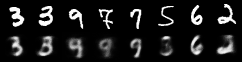

====> Test set BCE: 132.7297, Test set Loss: 148.9066
Epoch: 2 Average BCE: 125.5926, Average Loss: 144.0323
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


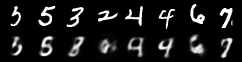

====> Test set BCE: 120.6370, Test set Loss: 137.8963
Epoch: 3 Average BCE: 112.1151, Average Loss: 132.6494
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


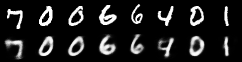

====> Test set BCE: 103.6598, Test set Loss: 125.0009
Epoch: 4 Average BCE: 104.4980, Average Loss: 126.2609
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


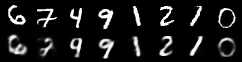

====> Test set BCE: 97.3403, Test set Loss: 119.9086
Epoch: 5 Average BCE: 100.0354, Average Loss: 122.5027
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


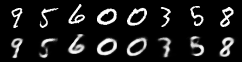

====> Test set BCE: 94.5005, Test set Loss: 117.5427
Epoch: 6 Average BCE: 96.8486, Average Loss: 119.7906
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


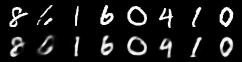

====> Test set BCE: 92.4405, Test set Loss: 115.5945
Epoch: 7 Average BCE: 94.5831, Average Loss: 117.9346
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


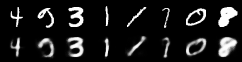

====> Test set BCE: 89.9451, Test set Loss: 113.6182
Epoch: 8 Average BCE: 92.7717, Average Loss: 116.3517
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


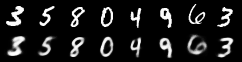

====> Test set BCE: 88.2626, Test set Loss: 112.5520
Epoch: 9 Average BCE: 91.4794, Average Loss: 115.2596
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


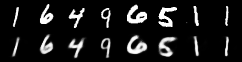

====> Test set BCE: 88.3439, Test set Loss: 111.9047
Epoch: 10 Average BCE: 90.3466, Average Loss: 114.2677
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


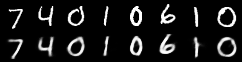

====> Test set BCE: 88.0142, Test set Loss: 112.2144
Epoch: 11 Average BCE: 89.4529, Average Loss: 113.4988
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


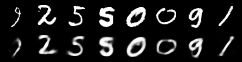

====> Test set BCE: 86.5664, Test set Loss: 110.5614
Epoch: 12 Average BCE: 88.7285, Average Loss: 112.8644
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


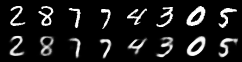

====> Test set BCE: 86.2354, Test set Loss: 110.3434
Epoch: 13 Average BCE: 88.0652, Average Loss: 112.2974
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


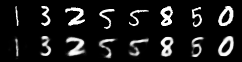

====> Test set BCE: 86.5521, Test set Loss: 110.6766
Epoch: 14 Average BCE: 87.5320, Average Loss: 111.8123
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


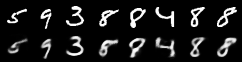

====> Test set BCE: 87.5623, Test set Loss: 110.5912
Epoch: 15 Average BCE: 87.1125, Average Loss: 111.4513
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


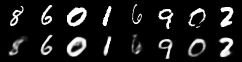

====> Test set BCE: 86.6541, Test set Loss: 110.5125
Epoch: 16 Average BCE: 86.6913, Average Loss: 111.0710
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


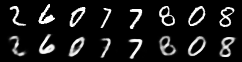

====> Test set BCE: 84.6260, Test set Loss: 108.6717
Epoch: 17 Average BCE: 86.3664, Average Loss: 110.8494
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


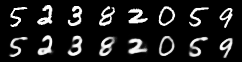

====> Test set BCE: 84.3554, Test set Loss: 108.8344
Epoch: 18 Average BCE: 85.7517, Average Loss: 110.2555
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


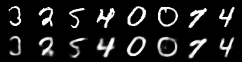

====> Test set BCE: 83.7527, Test set Loss: 108.2868
Epoch: 19 Average BCE: 85.6971, Average Loss: 110.2255
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


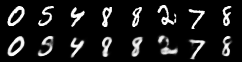

====> Test set BCE: 83.5058, Test set Loss: 107.8874
Epoch: 20 Average BCE: 85.2707, Average Loss: 109.8089
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


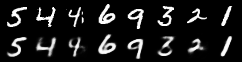

====> Test set BCE: 83.8116, Test set Loss: 108.0000
Epoch: 21 Average BCE: 85.1894, Average Loss: 109.7715
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


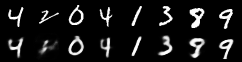

====> Test set BCE: 83.4155, Test set Loss: 107.8113
Epoch: 22 Average BCE: 84.8527, Average Loss: 109.4946
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


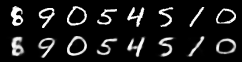

====> Test set BCE: 82.9617, Test set Loss: 107.6317
Epoch: 23 Average BCE: 84.6368, Average Loss: 109.2843
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


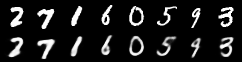

====> Test set BCE: 82.8387, Test set Loss: 107.1257
Epoch: 24 Average BCE: 84.4032, Average Loss: 109.0796
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


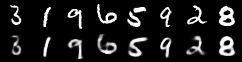

====> Test set BCE: 81.8778, Test set Loss: 106.9061
Epoch: 25 Average BCE: 84.2165, Average Loss: 108.8836
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


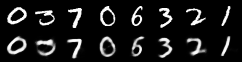

====> Test set BCE: 83.3457, Test set Loss: 107.5310
Epoch: 26 Average BCE: 84.0702, Average Loss: 108.7749
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


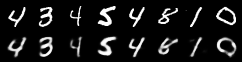

====> Test set BCE: 82.1406, Test set Loss: 106.9565
Epoch: 27 Average BCE: 83.9723, Average Loss: 108.6723
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


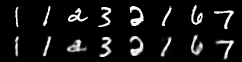

====> Test set BCE: 82.4050, Test set Loss: 106.8335
Epoch: 28 Average BCE: 83.7120, Average Loss: 108.4458
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


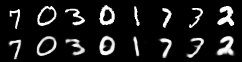

====> Test set BCE: 82.9024, Test set Loss: 107.5161
Epoch: 29 Average BCE: 83.5746, Average Loss: 108.2954
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


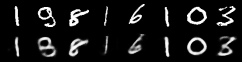

====> Test set BCE: 82.4213, Test set Loss: 106.7638
Epoch: 30 Average BCE: 83.5257, Average Loss: 108.2815
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


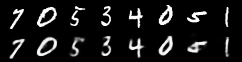

====> Test set BCE: 81.9908, Test set Loss: 106.5505
Epoch: 31 Average BCE: 83.4762, Average Loss: 108.2386
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


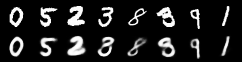

====> Test set BCE: 81.5467, Test set Loss: 106.4725
Epoch: 32 Average BCE: 83.2219, Average Loss: 108.0080
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


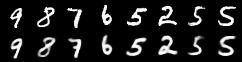

====> Test set BCE: 81.6517, Test set Loss: 106.5263
Epoch: 33 Average BCE: 83.0983, Average Loss: 107.9130
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


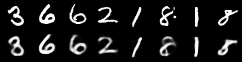

====> Test set BCE: 82.6283, Test set Loss: 106.9499
Epoch: 34 Average BCE: 82.9513, Average Loss: 107.7710
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


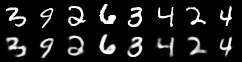

====> Test set BCE: 81.6369, Test set Loss: 106.0561
Epoch: 35 Average BCE: 82.7038, Average Loss: 107.5147
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


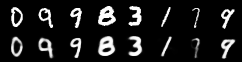

====> Test set BCE: 81.6216, Test set Loss: 106.1577
Epoch: 36 Average BCE: 82.8716, Average Loss: 107.6863
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


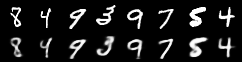

====> Test set BCE: 80.9689, Test set Loss: 105.7659
Epoch: 37 Average BCE: 82.7057, Average Loss: 107.5841
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


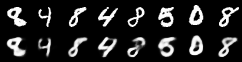

====> Test set BCE: 80.8967, Test set Loss: 105.7533
Epoch: 38 Average BCE: 82.5204, Average Loss: 107.4104
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


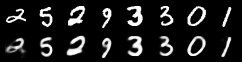

====> Test set BCE: 80.5848, Test set Loss: 105.7100
Epoch: 39 Average BCE: 82.6368, Average Loss: 107.5169
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


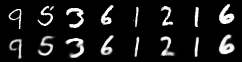

====> Test set BCE: 80.7225, Test set Loss: 105.8701
Epoch: 40 Average BCE: 82.3743, Average Loss: 107.2670
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


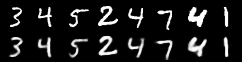

====> Test set BCE: 81.6714, Test set Loss: 106.1731
Epoch: 41 Average BCE: 82.2509, Average Loss: 107.1576
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


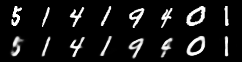

====> Test set BCE: 81.0730, Test set Loss: 105.5417
Epoch: 42 Average BCE: 82.3105, Average Loss: 107.2112
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


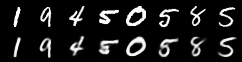

====> Test set BCE: 81.7268, Test set Loss: 106.2724
Epoch: 43 Average BCE: 82.0896, Average Loss: 106.9955
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


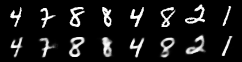

====> Test set BCE: 81.3325, Test set Loss: 106.3495
Epoch: 44 Average BCE: 82.0658, Average Loss: 106.9723
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


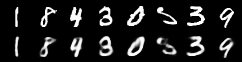

====> Test set BCE: 80.9379, Test set Loss: 105.8153
Epoch: 45 Average BCE: 82.0239, Average Loss: 106.9567
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


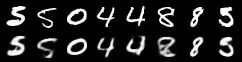

====> Test set BCE: 80.6729, Test set Loss: 105.7695
Epoch: 46 Average BCE: 81.8679, Average Loss: 106.8083
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


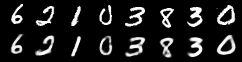

====> Test set BCE: 80.1796, Test set Loss: 105.4406
Epoch: 47 Average BCE: 81.9186, Average Loss: 106.8545
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


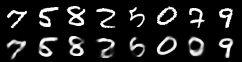

====> Test set BCE: 80.9761, Test set Loss: 105.6609
Epoch: 48 Average BCE: 81.8044, Average Loss: 106.7453
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


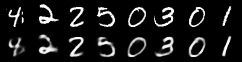

====> Test set BCE: 82.0520, Test set Loss: 106.5826
Epoch: 49 Average BCE: 81.7019, Average Loss: 106.6515
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


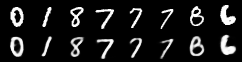

====> Test set BCE: 80.3246, Test set Loss: 105.1507
Epoch: 50 Average BCE: 81.7064, Average Loss: 106.6871
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


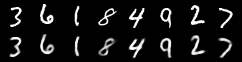

====> Test set BCE: 81.7171, Test set Loss: 106.0341


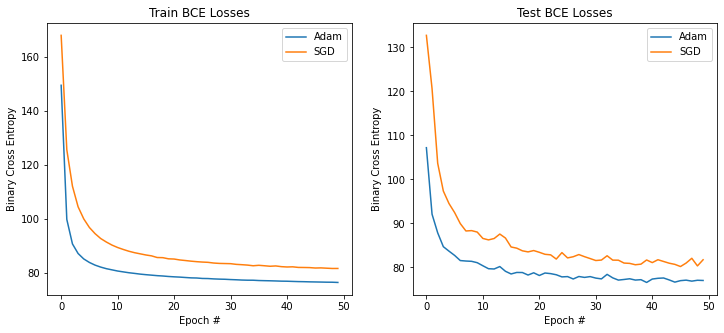

In [71]:
# train and test VAE with SGD
SGD_average_train_losses = []
SGD_average_train_BCE = []
SGD_average_test_losses = []
SGD_average_test_BCE = []
SGD_model = VAE().to(device)
SGD_optimizer = optim.SGD(SGD_model.parameters(), lr=1e-4)
print("==================== VAE =====================")
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(
        epoch, SGD_model, SGD_optimizer)
    SGD_average_train_losses.append(average_train_loss)
    SGD_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, SGD_model)
    SGD_average_test_losses.append(average_test_loss)
    SGD_average_test_BCE.append(average_test_BCE)

_, (a1, a2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot Train BCE Losses
a1.plot(vae_average_train_BCE)
a1.plot(SGD_average_train_BCE)
a1.set_title('Train BCE Losses')
a1.set_ylabel('Binary Cross Entropy')
a1.set_xlabel('Epoch #')
a1.legend(['Adam', 'SGD'], loc='upper right')

# Plot Test BCE Losses
a2.plot(vae_average_test_BCE)
a2.plot(SGD_average_test_BCE)
a2.set_title('Test BCE Losses')
a2.set_ylabel('Binary Cross Entropy')
a2.set_xlabel('Epoch #')
a2.legend(['Adam', 'SGD'], loc='upper right')
plt.show()


Adam performs better than SGD, since SGD takes longer to converge. We can also observe this by looking at the reconstructed images using SGD and Adam. For SGD, the reconstructed image has a clearer edge and looks more identical to the original image starting at epoch 26, while for Adam, it starts at epoch 17. When calculating the gradient, SGD is easier to find a saddle point instead of the local minima, so the algorithm takes more iterations to converge. Adam is faster to converge and performs better at the end of optimization as gradients become sparser.